### importing the libraries and preprocessing the data

In [97]:
import os
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from wordcloud import WordCloud
import nltk
import re
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize




In [98]:
%matplotlib inline

In [99]:
warnings.filterwarnings('ignore')

## Dataset Description

The dataset comprises about 24,000 summaries written by students in grades 3-12 of passages on a variety of topics and genres. These summaries have been assigned scores for both content and wording.

### File and Field Information

* summaries_train.csv - Summaries in the training set.
 * student_id - The ID of the student writer.
 * prompt_id - The ID of the prompt which links to the prompt file.
 * text - The full text of the student's summary.
 * content - The content score for the summary. The first target.
 * wording - The wording score for the summary. The second target.
* summaries_test.csv - Summaries in the test set. Contains all fields above except content and wording.
* prompts_train.csv - The four training set prompts. Each prompt comprises the complete summarization assignment given to students.
 * prompt_id - The ID of the prompt which links to the summaries file.
 * prompt_question - The specific question the students are asked to respond to.
 * prompt_title - A short-hand title for the prompt.
 * prompt_text - The full prompt text.
* prompts_test.csv - The test set prompts. Contains the same fields as above. The prompts here are only an example. The full test set has a large number of prompts. The train / public test / private test splits do not share any prompts.
*sample_submission.csv - A submission file in the correct format

In [100]:
# This is how a sample submission looks
df_samplesub=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/sample_submission.csv")
df_samplesub.head()

,student_id,content,wording
0,000000ffffff,0.0,0.0
1,111111eeeeee,0.0,0.0
2,222222cccccc,0.0,0.0
3,333333dddddd,0.0,0.0


In [101]:
df_train_summ=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv")
print("Shape of df_train_text: ",df_train_summ.shape)
df_train_summ.head()

Shape of df_train_text:  (7165, 5)


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [102]:
df_train_summ.describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


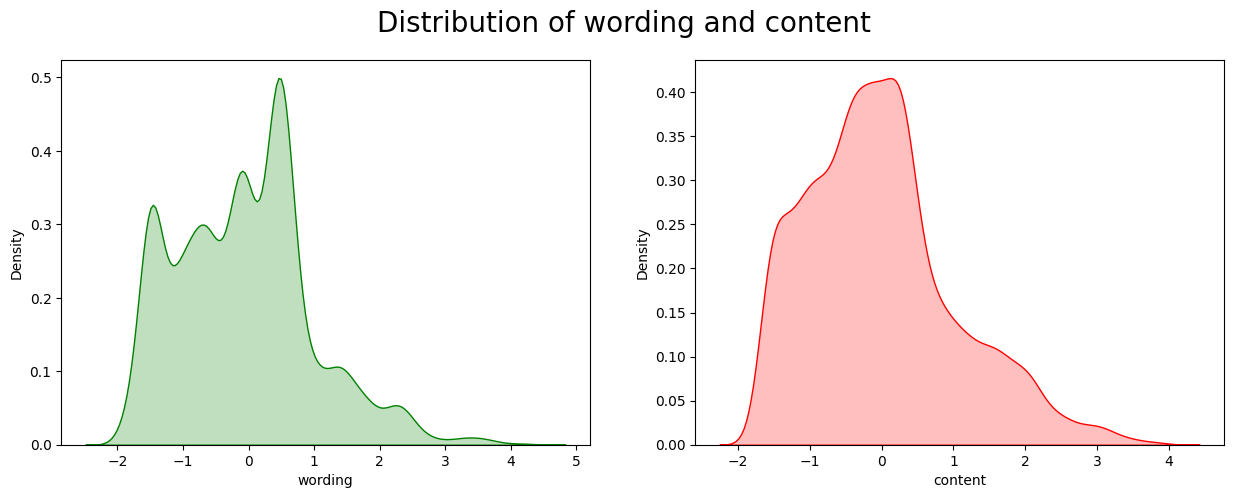

In [103]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(15,5)
fig.suptitle("Distribution of wording and content", fontsize=20)
sns.kdeplot(df_train_summ['wording'], shade=True, ax=ax[0], color='green')
sns.kdeplot(df_train_summ['content'], shade=True, ax=ax[1], color='red')
fig.show()

In [104]:
df_train_prompts=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv")
print("Shape of df_test_p: ",df_train_prompts.shape)
df_train_prompts.head(1)

Shape of df_test_p:  (4, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...


In [105]:
df_test_summ=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv")
print("Shape of df_test_text: ",df_test_summ.shape)
df_test_summ.head()

Shape of df_test_text:  (4, 3)


,student_id,prompt_id,text
0,000000ffffff,abc123,Example text 1
1,111111eeeeee,def789,Example text 2
2,222222cccccc,abc123,Example text 3
3,333333dddddd,def789,Example text 4


In [106]:
df_test_prompts=pd.read_csv("/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv")
print("Shape of df_test_p: ",df_test_prompts.shape)
df_test_prompts.head()

Shape of df_test_p:  (2, 4)


,prompt_id,prompt_question,prompt_title,prompt_text
0,abc123,Summarize...,Example Title 1,Heading\nText...
1,def789,Summarize...,Example Title 2,Heading\nText...


We won't show the whole EDA pipeline here, as we focusing on the validation part. So, if you want to see the full EDA pipeline, please refer to [Practice1.ipynb](https://github.com/geeeeenccc/NLP-Course-IASA-Homework/blob/04f5305e6ca15393685ed71d647653a50a6332b6/Homework%201/Practice1.ipynb).

Anyway what we will do before getting to the validation part is to convert the text in the "text" column of your DataFrame to lowercase, and then replace any non-alphanumeric characters with a space.

In [107]:
# Let's do a text transformation

# Convert the text in the "text" column of  DataFrame to lowercase.
df_train_summ["transformed_text"]=df_train_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_train_summ["transformed_text"]=df_train_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))
# Convert the text in the "text" column of  DataFrame to lowercase.
df_test_summ["transformed_text"]=df_test_summ.text.str.lower()
# Finally, use the re.sub() function to replace any non-alphanumeric characters with a space.
df_test_summ["transformed_text"]=df_test_summ["transformed_text"].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x))

In [108]:
print("Transformed Text: ",df_train_summ["transformed_text"][0])

Transformed Text:  the third wave was an experimentto see how people reacted to a new one leader government it gained popularity as people wanted to try new things the students follow anything that is said and start turning on eachother to gain higher power they had to stop the experement as too many people got to radical with it blindly following there leader


In [109]:
nltk.download('stopwords')

stopwords=nltk.corpus.stopwords
stopwords=stopwords.words('english')

stopwords[:10]

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [110]:
# Some other feature engineering functions:
# 1. Total number of words
# 2. Number of stopwords
# 3. Number of punctuation
# 4. Number of numbers
# 5. Implement the feature engineering
def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords)
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineering(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [111]:
df_train_summ = feature_engineering(df_train_summ)
df_test_summ = feature_engineering(df_test_summ)

As we did in Practice 2, we will use the TfidfVectorizer to vectorize the text.

 Then we will concatenate the vectorized data with the training and test data.

And finally, after that, we can start working on the validation part.

In [112]:
# Selection of the features we will use to train the model
features = df_train_summ.drop(columns = ['student_id', 'prompt_id', 'text', 'transformed_text', 'content', 'wording'], axis = 1).columns

## Modeling

In [113]:
# Define your model and tokenizer
model_name = "/kaggle/input/hugging-face-models-safe-tensors/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/hugging-face-models-safe-tensors/deberta-v3-base and are newly initialized: ['pooler.dense.bias', 'classifier.weight', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Group K-fold CV

We will have only 4 folds as we have 4 unique prompt_ids.

In [114]:
# Define the number of folds
num_folds = 4  

# Perform GroupKFold split
group_kfold = GroupKFold(n_splits=num_folds)

# Lists to store results
content_preds_list = []
wording_preds_list = []

In [115]:
class CommonLitDataset(Dataset):
    def __init__(self, texts, content_labels, wording_labels, tokenizer, max_length):
        self.texts = texts
        self.content_labels = content_labels
        self.wording_labels = wording_labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        content_label = torch.tensor(self.content_labels[idx], dtype=torch.float32)
        wording_label = torch.tensor(self.wording_labels[idx], dtype=torch.float32)
        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'content_label': content_label,
            'wording_label': wording_label
        }


In [116]:
max_length = 256  # You can adjust this based on your resources and performance
batch_size = 8  # You can adjust this based on your GPU memory
epochs = 1  # Change to more epochs when you wish to submit via this approach
lr = 1e-5

In [117]:
# Training loop
model.to(device)

for fold, (train_idx, val_idx) in enumerate(group_kfold.split(df_train_summ, groups=df_train_summ['prompt_id'])):
    print(f"Fold {fold + 1}/{num_folds}")

    # Extract train and validation data based on the fold
    train_texts = df_train_summ['text'].iloc[train_idx].tolist()
    val_texts = df_train_summ['text'].iloc[val_idx].tolist()
    content_labels = df_train_summ['content'].iloc[train_idx].tolist()
    val_content_labels = df_train_summ['content'].iloc[val_idx].tolist()
    wording_labels = df_train_summ['wording'].iloc[train_idx].tolist()
    val_wording_labels = df_train_summ['wording'].iloc[val_idx].tolist()

    # Create datasets and dataloaders for the current fold
    train_dataset = CommonLitDataset(train_texts, content_labels, wording_labels, tokenizer, max_length)
    val_dataset = CommonLitDataset(val_texts, val_content_labels, val_wording_labels, tokenizer, max_length)

    batch_size = 8  # You can adjust this based on your GPU memory
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    epochs = 1  # Change to more epochs when you wish to submit via this approach
    lr = 1e-5
    optimizer = AdamW(model.parameters(), lr=lr)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * epochs)

    # Training loop
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()
        for step, batch in tqdm(enumerate(train_dataloader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            content_labels = batch['content_label'].to(device)
            wording_labels = batch['wording_label'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            content_preds = outputs.logits[:, 0]
            wording_preds = outputs.logits[:, 1]

            content_loss = torch.nn.MSELoss()(content_preds, content_labels)
            wording_loss = torch.nn.MSELoss()(wording_preds, wording_labels)
            total_loss = content_loss + wording_loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            if step % 100 == 0:
                print("Step :: {}  - Total Loss :: {}".format(step, total_loss.item()))

        # Validation
        model.eval()
        val_loss_content = 0.0
        val_loss_wording = 0.0
        val_steps = 0
        with torch.no_grad():
            for batch in tqdm(val_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                content_labels = batch['content_label'].to(device)
                wording_labels = batch['wording_label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                content_preds = outputs.logits[:, 0]
                wording_preds = outputs.logits[:, 1]

                val_loss_content += torch.nn.MSELoss()(content_preds, content_labels).item()
                val_loss_wording += torch.nn.MSELoss()(wording_preds, wording_labels).item()
                val_steps += 1

        val_loss_content /= val_steps
        val_loss_wording /= val_steps
        print(f"Epoch {epoch + 1}/{epochs} - Content Loss: {val_loss_content:.4f}, Wording Loss: {val_loss_wording:.4f}")

    # Model evaluation on the test set for this fold
    test_texts = df_test_summ['text'].tolist()
    test_dataset = CommonLitDataset(test_texts, [0.0] * len(test_texts), [0.0] * len(test_texts), tokenizer, max_length)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    model.eval()
    content_preds = []
    wording_preds = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            content_preds.extend(outputs.logits[:, 0].cpu().numpy())
            wording_preds.extend(outputs.logits[:, 1].cpu().numpy())

    content_preds_list.append(content_preds)
    wording_preds_list.append(wording_preds)

Fold 1/4


1it [00:00,  3.24it/s]

Step :: 0  - Total Loss :: 2.2727184295654297


101it [00:29,  3.39it/s]

Step :: 100  - Total Loss :: 0.993770956993103


201it [00:58,  3.39it/s]

Step :: 200  - Total Loss :: 1.087073802947998


301it [01:27,  3.40it/s]

Step :: 300  - Total Loss :: 1.6942837238311768


401it [01:57,  3.39it/s]

Step :: 400  - Total Loss :: 0.4985131025314331


501it [02:26,  3.39it/s]

Step :: 500  - Total Loss :: 0.35878250002861023


601it [02:55,  3.39it/s]

Step :: 600  - Total Loss :: 0.41541463136672974


639it [03:06,  3.42it/s]
100%|██████████| 258/258 [00:23<00:00, 10.85it/s]


Epoch 1/1 - Content Loss: 0.2361, Wording Loss: 0.4470
Fold 2/4


1it [00:00,  3.30it/s]

Step :: 0  - Total Loss :: 0.5187578797340393


101it [00:29,  3.39it/s]

Step :: 100  - Total Loss :: 0.49276235699653625


201it [00:58,  3.39it/s]

Step :: 200  - Total Loss :: 0.14601127803325653


301it [01:27,  3.39it/s]

Step :: 300  - Total Loss :: 0.4521043598651886


401it [01:57,  3.39it/s]

Step :: 400  - Total Loss :: 0.2559087872505188


501it [02:26,  3.39it/s]

Step :: 500  - Total Loss :: 0.29265522956848145


601it [02:55,  3.39it/s]

Step :: 600  - Total Loss :: 0.4026094675064087


645it [03:08,  3.42it/s]
100%|██████████| 252/252 [00:23<00:00, 10.85it/s]


Epoch 1/1 - Content Loss: 0.2249, Wording Loss: 0.5115
Fold 3/4


1it [00:00,  3.30it/s]

Step :: 0  - Total Loss :: 1.0223517417907715


101it [00:29,  3.39it/s]

Step :: 100  - Total Loss :: 1.0351743698120117


201it [00:58,  3.39it/s]

Step :: 200  - Total Loss :: 0.5658562183380127


301it [01:28,  3.38it/s]

Step :: 300  - Total Loss :: 0.15755830705165863


401it [01:57,  3.39it/s]

Step :: 400  - Total Loss :: 0.6457803249359131


501it [02:26,  3.39it/s]

Step :: 500  - Total Loss :: 0.38074517250061035


601it [02:55,  3.39it/s]

Step :: 600  - Total Loss :: 0.20702838897705078


647it [03:08,  3.42it/s]
100%|██████████| 250/250 [00:23<00:00, 10.82it/s]


Epoch 1/1 - Content Loss: 0.1600, Wording Loss: 0.2153
Fold 4/4


1it [00:00,  3.30it/s]

Step :: 0  - Total Loss :: 0.2610023617744446


101it [00:29,  3.38it/s]

Step :: 100  - Total Loss :: 0.41165822744369507


201it [00:58,  3.39it/s]

Step :: 200  - Total Loss :: 0.39222705364227295


301it [01:28,  3.39it/s]

Step :: 300  - Total Loss :: 0.40757399797439575


401it [01:57,  3.40it/s]

Step :: 400  - Total Loss :: 0.7293113470077515


501it [02:26,  3.39it/s]

Step :: 500  - Total Loss :: 0.21541422605514526


601it [02:55,  3.39it/s]

Step :: 600  - Total Loss :: 0.38312220573425293


701it [03:25,  3.39it/s]

Step :: 700  - Total Loss :: 0.338959276676178


758it [03:41,  3.42it/s]
100%|██████████| 138/138 [00:12<00:00, 10.85it/s]


Epoch 1/1 - Content Loss: 0.1692, Wording Loss: 0.3873


In [122]:
content_preds_list

[[-1.0847384, -1.1055461, -1.1768, -1.184251],
 [-1.1857902, -1.2126714, -1.2719706, -1.2628022],
 [-1.3698626, -1.4067072, -1.4765358, -1.4602191],
 [-1.3765928, -1.423199, -1.459661, -1.4420172]]

In [123]:
test_data['student_id']

0    000000ffffff
1    111111eeeeee
2    222222cccccc
3    333333dddddd
Name: student_id, dtype: object

In [127]:
# Combine predictions from different folds
content_preds = np.mean(content_preds_list, axis=0)
wording_preds = np.mean(wording_preds_list, axis=0)

In [128]:
# Ensure that the lengths match
num_predictions = len(content_preds)

# Create the submission DataFrame with matching lengths
submission_df = pd.DataFrame({
    'student_id': test_data['student_id'].iloc[:num_predictions],  # Adjust the index range as needed
    'content': content_preds,
    'wording': wording_preds
})
submission_df.to_csv('submission.csv', index=False)

In [129]:
submission_df

,student_id,content,wording
0,000000ffffff,-1.254246,-1.094453
1,111111eeeeee,-1.287031,-1.105251
2,222222cccccc,-1.346242,-1.140600
3,333333dddddd,-1.337322,-1.136716
